## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with nuisance parameters based on the different livetimes

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator
from scipy.interpolate import interp2d

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix

from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)

## Read dataset

In [2]:
c = Dataset_load.load_config()
awo, aw, ewo, ew = c['_colors']  

In [3]:
livetime = c['livetime']
zero = c['zero'] 
norm = c['norm'] 
tilt = c['tilt'] 
bias = c['bias'] 
resolution = c['resolution'] 
magnitude = c['magnitude'] 
corrlength = c['corrlength']
sys = c['sys'] 
folder = c['folder']
parameter_names = c['parameter_names']        
nbidx = 0
print(livetime)
print(folder)

2.154434690031884
Combined100_PKSflare_crab_cutoff


In [4]:
%%time
dataset_input  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                               livetime = f"{livetime}-hr",
                                        parameters = None)


loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/Dataset/datasets/dataset-simulated-2.154434690031884-hr.fits.gz
CPU times: user 6.09 s, sys: 201 ms, total: 6.29 s
Wall time: 6.31 s


## Datasets

In [5]:
    
setup = Setup(dataset_input=dataset_input)
#setup.set_up_irf_sys(bias, resolution, norm, tilt)
dataset_asimov, dataset_asimov_N = setup.run()
# irf model
setup.set_irf_model(dataset_asimov_N)
if  "Eff_area" in sys:
    dataset_asimov_N.models.parameters['resolution'].frozen = True
    dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
    dataset_asimov_N.irf_model.parameters['bias'].frozen = True
    setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)


/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:343: GammapyDeprecationWarning: obs_info property is deprecated since v1.2. Use meta instead.
  warnings.warn(


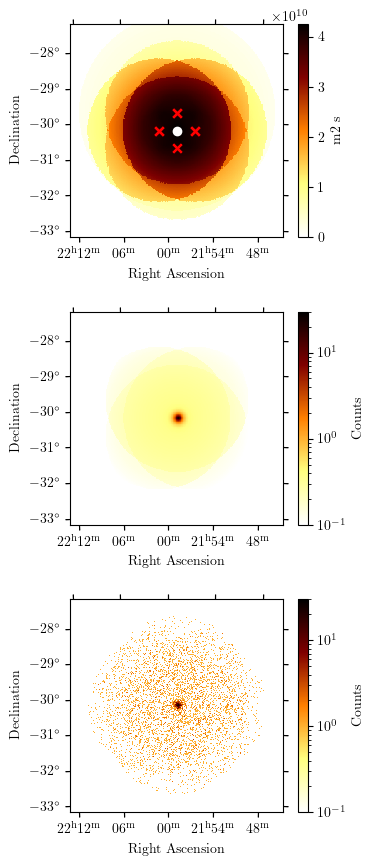

In [6]:
fig  = plt.figure(figsize = (4,9))# , axs = plt.subplots(3,1, projection=dataset_asimov._geom.wcs)


dataset_stat = dataset_asimov.copy()
dataset_stat.counts.data = np.random.poisson(dataset_asimov.npred().data)
from matplotlib.colors import LogNorm
geom = dataset_stat.counts._geom


maps = [dataset_stat.exposure, dataset_asimov.npred(), dataset_stat.counts]
ax1 = fig.add_subplot(3,1, 1, projection=geom.wcs)
ax2 = fig.add_subplot(3,1, 2, projection=geom.wcs)
ax3 = fig.add_subplot(3,1, 3, projection=geom.wcs)
axs = [ax1, ax2, ax3]
for i,m in enumerate(maps):
    ax = axs[i]
    if i == 0:
        norm = None
    else:
        norm  =  LogNorm(vmin = 0.1, vmax = 30)
    m.sum_over_axes().plot(add_cbar = 1,norm =norm, cmap = "afmhot_r", ax = ax,)
    
#ax1.set_title("Exposure")
#ax2.set_title("Model Prediction")
#ax3.set_title("Simulated Counts")


from gammapy.data import DataStore
path_ = '/home/wecapstor1/caph/mppi045h/fits_paper_data/std_fullEnclosure/pks2155_flare/out'
data_store = DataStore.from_dir(path_, f'hdu-index-bg-v05-fov-radec.fits.gz', f'obs-index-bg-v05-fov-radec.fits.gz')
observations = data_store.get_observations(data_store.obs_ids)
ra_pnt, dec_pnt = [], []
for obs in observations:
    ra_pnt.append(obs.obs_info['RA_PNT'])
    dec_pnt.append(obs.obs_info['DEC_PNT'])
for i in range(len(observations)):
    ax1.scatter(ra_pnt[i], dec_pnt[i], marker = 'x', color ='red',
              transform=ax1.get_transform("icrs"))
ax1.scatter(obs.obs_info['RA_OBJ'], obs.obs_info['DEC_OBJ'] , marker = 'o',  color = 'white',
            transform=ax1.get_transform("icrs"))

cbar = ax2.images[-1].colorbar
cbar.set_label('Counts' , rotation=90)
cbar = ax3.images[-1].colorbar
cbar.set_label('Counts' , rotation=90)

for ax in axs:
    xx = ax.get_xlim()
    delta = 100
    ax.set_xlim(xx[0] + delta, xx[1] - delta)

    xx = ax.get_ylim()
    ax.set_ylim(xx[0] + delta, xx[1] - delta)

plt.tight_layout()
fig.subplots_adjust(hspace= 0.35)
fig.savefig(f"../{folder}/plots/7_exposure_model_counts.pdf")

/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:343: GammapyDeprecationWarning: obs_info property is deprecated since v1.2. Use meta instead.
  warnings.warn(
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:343: GammapyDeprecationWarning: obs_info property is deprecated since v1.2. Use meta instead.
  warnings.warn(
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:343: GammapyDeprecationWarning: obs_info property is deprecated since v1.2. Use meta instead.
  warnings.warn(


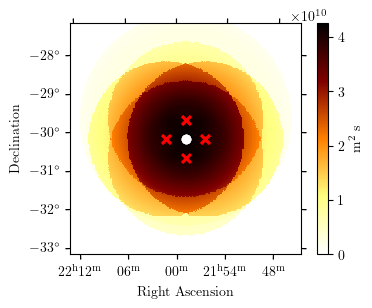

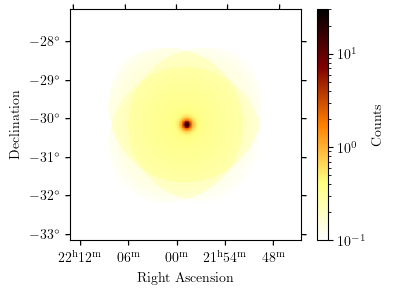

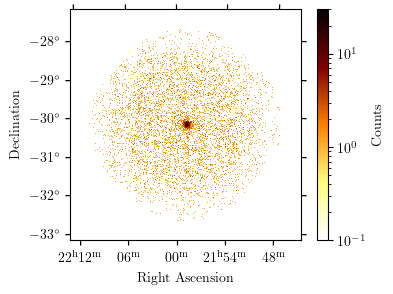

In [7]:


dataset_stat = dataset_asimov.copy()
dataset_stat.counts.data = np.random.poisson(dataset_asimov.npred().data)
from matplotlib.colors import LogNorm
geom = dataset_stat.counts._geom


maps = [dataset_stat.exposure, dataset_asimov.npred(), dataset_stat.counts]
for i,m in enumerate(maps):
    fig  = plt.figure(figsize = (4,3))# , axs = plt.subplots(3,1, projection=dataset_asimov._geom.wcs)
    if i == 0:
        ax1 = fig.add_subplot(1,1, 1, projection=geom.wcs)
        ax = ax1
        abc = 'a'
    if i ==1:
        ax2 = fig.add_subplot(1,1, 1, projection=geom.wcs)
        ax = ax2
        abc = 'b'
        
    if i == 2:
        ax3 = fig.add_subplot(1,1, 1, projection=geom.wcs)
        ax = ax3
        abc = 'c'
        
    if i == 0:
        norm = None
    else:
        norm  =  LogNorm(vmin = 0.1, vmax = 30)
    m.sum_over_axes().plot(add_cbar = 1,norm =norm, cmap = "afmhot_r", ax = ax, )
    if i == 0:
        cbar = ax.images[-1].colorbar
        cbar.set_label('m$^2$ s' , rotation=90)
    else:
        cbar = ax.images[-1].colorbar
        cbar.set_label('Counts' , rotation=90)


        
    from gammapy.data import DataStore
    path_ = '/home/wecapstor1/caph/mppi045h/fits_paper_data/std_fullEnclosure/pks2155_flare/out'
    data_store = DataStore.from_dir(path_, f'hdu-index-bg-v05-fov-radec.fits.gz', f'obs-index-bg-v05-fov-radec.fits.gz')
    observations = data_store.get_observations(data_store.obs_ids)
    ra_pnt, dec_pnt = [], []
    for obs in observations:
        ra_pnt.append(obs.obs_info['RA_PNT'])
        dec_pnt.append(obs.obs_info['DEC_PNT'])
    for i in range(len(observations)):
        ax1.scatter(ra_pnt[i], dec_pnt[i], marker = 'x', color ='red',
                  transform=ax1.get_transform("icrs"))
    ax1.scatter(obs.obs_info['RA_OBJ'], obs.obs_info['DEC_OBJ'] , marker = 'o',  color = 'white',
                transform=ax1.get_transform("icrs"))

    for ax in [ax]:
        xx = ax.get_xlim()
        delta = 100
        ax.set_xlim(xx[0] + delta, xx[1] - delta)

        xx = ax.get_ylim()
        ax.set_ylim(xx[0] + delta, xx[1] - delta)
        
    fig.set_size_inches(4,3)
    fig.savefig(f"../{folder}/plots/7_exposure_model_counts{abc}.pdf",
               bbox_inches = "tight")

In [8]:
numpoints = 20      
e_reco_n = 1000
scan_n_values= 5
def read_in_contour(note, numpoints = 5 , folder = '', e_reco_n= e_reco_n,
                       scan_n_values = scan_n_values):
        results = []
        for parname1, parname2 in parameter_names :
            with open(f"{folder}data/3_contour_surface_{note}_{parname1}_{parname2}_{scan_n_values}_{e_reco_n}.yml", "r") as stream:
                    contour = yaml.safe_load(stream)

            results.append(contour)
        return results



In [9]:
if "Combined" in sys:
    e_reco_n =1000
    scan_n_values = 20

    results_comb = read_in_contour('2.15h',folder = '../Combined100_PKSflare_crab_cutoff/',
                                   scan_n_values = scan_n_values)
    results_N_comb = read_in_contour('N_2.15h',folder = '../Combined100_PKSflare_crab_cutoff/',
                                     scan_n_values = scan_n_values)

        
    path = f'../Combined100_PKSflare_crab_cutoff/data/0_model_livetime_{livetime}_np.yml'
    dataset_asimov.models = Models.read(path)


contour_eff = 1
if contour_eff:
    results_eff = read_in_contour("2.15h", folder = "../Eff_area100_PKSflare_crab_cutoff/",
                                 e_reco_n = 10, scan_n_values = 20)
    results_N_eff = read_in_contour("N_2.15h", folder = "../Eff_area100_PKSflare_crab_cutoff/",
                                   e_reco_n = 10, scan_n_values = 20)

    
contour_ereco = 1
if contour_ereco:
    results_N_ereco = read_in_contour("N_2.15h" ,folder = '../E_reco_PKSflare_crab_cutoff/'
                                      , scan_n_values = 20)
    results_ereco = read_in_contour("2.15h" ,folder = '../E_reco_PKSflare_crab_cutoff/',
                                    scan_n_values = 20)
    
    
try:
    path = f'../{folder}/data/0_model_nui_livetime_{livetime}_np.yml'
    dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path,bkg_sys = False)        
except:    
    print("CAUTION: symmetric errors")
    path = f'../{folder}/data/0_model_nui_livetime_{livetime}_2000.yml'
    dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path,bkg_sys = False)        
    for p in np.array(parameter_names).flatten():
        dataset_asimov_N.models.parameters[p].error_n =   dataset_asimov_N.models.parameters[p].error         
        dataset_asimov_N.models.parameters[p].error_p =   dataset_asimov_N.models.parameters[p].error 
    
        
if "Combined" in sys:
    results_N = results_N_comb
    results = results_comb
if "E_reco" in sys:
    results_N = results_N_ereco
    results = results_ereco
if "Eff_area" in sys:
    results_N = results_N_eff
    results = results_eff
    
    

In [10]:
print(dataset_asimov.models.parameters['index'].error)
print(dataset_asimov.models.parameters['index'].error_n)
print(dataset_asimov.models.parameters['index'].error_p)
print(dataset_asimov.models.parameters['index'].error)

0.09232004913014927
0.09583988422704826
0.09019532662839991
0.09232004913014927


In [11]:
colors_dark = ['darkred', 'midnightblue']

In [12]:
from scipy.interpolate import interp1d

def remove_duplicates(a, b):
    filtered_a = []
    filtered_b = []
    unique_values = {}
    for x, y in zip(a, b):
        if x not in unique_values:
            unique_values[x] = y
            filtered_a.append(x)
            filtered_b.append(y)
    return filtered_a, filtered_b

def interpolate(one, two):
    one, two =  rearange(one,two)
    one, two =  remove_duplicates(one,two)
    
    points = np.column_stack((one, two))  # a (nbre_points x nbre_dim) array
    

    # Linear length along the line:
    distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
    distance = np.insert(distance, 0, 0)/distance[-1]

    # Interpolation for different methods: #quadratic
    interpolations_methods = ['quadratic']
    alpha = np.linspace(0, 1, 75)

    interpolated_points = {}
    for method in interpolations_methods:
        interpolator =  interp1d(distance, points, kind=method, axis=0)
        interpolated_points[method] = interpolator(alpha)
        
    for method_name, curve in interpolated_points.items():
        c_int = {'x':curve.T[0], 'y': curve.T[1]}
        
    a,b = list(c_int['x']), list(c_int['y'])
    a.append(a[0])
    b.append(b[0])
    return a,b


def rearange(a,b):
    centroid = (sum(a) / len(a), sum(b) / len(b))

    def angle_from_centroid(x, y):
        return np.arctan2(y - centroid[1], x - centroid[0])

    contour_points = [(x, y) for x, y in zip(a, b)]
    contour_points.sort(key=lambda point: angle_from_centroid(point[0], point[1]))

    if np.cross(np.array(contour_points[1]) - np.array(contour_points[0]), 
                np.array(contour_points[-1]) - np.array(contour_points[0])) < 0:
        contour_points.reverse()
        
    #contour_points.append(contour_points[0])
    a, b = zip(*contour_points)
    return a,b

In [13]:
dataset_asimov_N.models.parameters['amplitude'].value *= 1e11
dataset_asimov_N.models.parameters['amplitude'].error *= 1e11
dataset_asimov_N.models.parameters['amplitude'].error_n *= 1e11
dataset_asimov_N.models.parameters['amplitude'].error_p *= 1e11


dataset_asimov.models.parameters['amplitude'].value *= 1e11
dataset_asimov.models.parameters['amplitude'].error *= 1e11
dataset_asimov.models.parameters['amplitude'].error_n *= 1e11
dataset_asimov.models.parameters['amplitude'].error_p *= 1e11

dataset_input.models.parameters['amplitude'].value *= 1e11

In [14]:
import colors as l

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


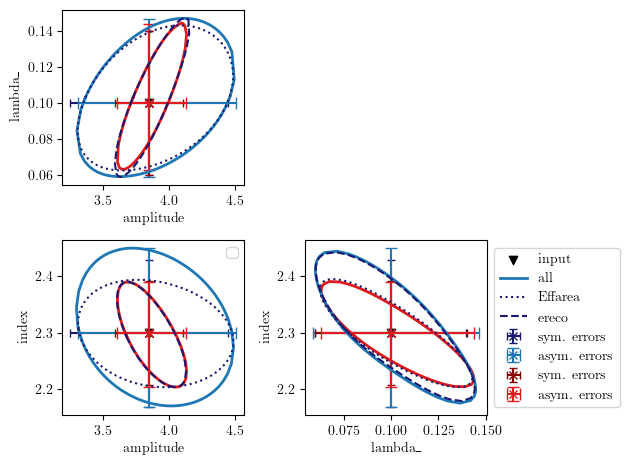

In [15]:
def contour_plot(axs, sys_errors = False, linewidth= 2):
    alpha = 0.2
    
    #fig,axs = plt.subplots(2,2)
    #axs = axs.flatten()
    #axs = [axs[1][0], axs[0][0], axs[1][1], axs[0][1]]
    for i,p in enumerate(parameter_names):
        a = results[i][f'{dataset_asimov.models[0].name}.spectral.{p[0]}']    
        if p[0] == "amplitude":
            a = np.array(a)*1e11
        b = results[i][f'{dataset_asimov.models[0].name}.spectral.{p[1]}']
        a,b = interpolate(a,b)    
        axs[i].plot(a, b, color = awo[0], linewidth = linewidth,
                   )
        #for j, d in enumerate([dataset_asimov, dataset_asimov_N]):
        for j, d in enumerate([dataset_asimov_N, dataset_asimov]):
            xen = d.models[0].parameters[p[0]].error_n
            xep = d.models[0].parameters[p[0]].error_p
            yen = d.models[0].parameters[p[1]].error_n
            yep = d.models[0].parameters[p[1]].error_p
            
            x = d.models[0].parameters[p[0]].value
            y = d.models[0].parameters[p[1]].value
            xe = d.models[0].parameters[p[0]].error
            ye = d.models[0].parameters[p[1]].error
            if sys_errors:
                axs[i].errorbar(x, y, xerr=np.array([[xe ,xe]]).T,
                            yerr=np.array([[ye ,ye]]).T, color = colors_dark[::-1][j], capsize = 3,
                fmt='x', label = "sym. errors")
            axs[i].errorbar(x, y, xerr=np.array([[xen ,xep]]).T,
                            yerr=np.array([[yen ,yep]]).T, color = colors_[::-1][j], capsize = 4,
                fmt='x',
                           label = "asym. errors")
            
           
        #a = results_N[i][f'{dataset_asimov.models[0].name}.spectral.{p[0]}']    
        #b = results_N[i][f'{dataset_asimov.models[0].name}.spectral.{p[1]}']
        #axs[i].plot(a, b, color = aw[0])
        axs[i].scatter (dataset_input.models[0].parameters[p[0]].value,
                         dataset_input.models[0].parameters[p[1]].value,
                        color = 'black',
                        marker = 'v',
                        label = "input"
                       )
        axs[i].set_xlabel(p[0])
        axs[i].set_ylabel(p[1]) 
        
        a = results_N[i][f'{dataset_asimov.models[0].name}.spectral.{p[0]}']    
        b = results_N[i][f'{dataset_asimov.models[0].name}.spectral.{p[1]}']
        if p[0] == "amplitude":
            a = np.array(a)*1e11
        #axs[i].plot(a, b, color = aw[0],# linestyle = 'solid',linewidth = linewidth,
        #           label = "all",linestyle = '', marker = 'x' )
        a,b = interpolate(a,b)
        axs[i].plot(a,b, color = aw[0], linestyle = 'solid',linewidth = linewidth,
                    label = "all" )
        linewidth_ = 1.5
        if contour_eff:
            a = results_N_eff[i][f'{dataset_asimov.models[0].name}.spectral.{p[0]}']    
            b = results_N_eff[i][f'{dataset_asimov.models[0].name}.spectral.{p[1]}']
            if p[0] == "amplitude":
                a = np.array(a)*1e11
            axs[i].plot(a, b, color = 'midnightblue', linestyle = 'dotted',
                       label = "Effarea", linewidth = linewidth_)
        if contour_ereco:
            a = results_N_ereco[i][f'{dataset_asimov.models[0].name}.spectral.{p[0]}']    
            b = results_N_ereco[i][f'{dataset_asimov.models[0].name}.spectral.{p[1]}']
            if p[0] == "amplitude":
                a = np.array(a)*1e11
            a,b = interpolate(a,b)
            axs[i].plot(a, b, color = 'midnightblue', linestyle = 'dashed',
                       label = "ereco",linewidth = linewidth_ )
            
       
    
    return axs

fig,axs = plt.subplots(2,2)
colors_ = [awo[0], aw[0]]
#axs = axs.flatten()
axs[1][0].legend()

axs = [axs[1][0], axs[0][0], axs[1][1], axs[0][1]]
contour_plot(axs, sys_errors= True)
axs[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
axs[-1].axis('off')
plt.savefig(f"../{c['folder']}/plots/7_contours.pdf")

### RNDs

In [16]:
c['folder']

'Combined100_PKSflare_crab_cutoff'

In [17]:
infos = np.loadtxt(f"../{c['folder']}/data/1_P_draw_info.txt")
N_max = 1000
shift_rnds = infos[:N_max, 0]
index_rnds = infos[:N_max, 1]
bias_rnds = infos[:N_max, 2]
res_rnds = infos[:N_max, 3]


pars_N = np.loadtxt(f"../{c['folder']}/data/1_N_P_draw_par.txt")
pars = np.loadtxt(f"../{c['folder']}/data/1_P_draw_par.txt")

lives = pars_N[:N_max, -1:]
results_rnds, results_rnds_N = [], []
path = f'../{folder}'
for i in range(len(shift_rnds)):
    s_ = shift_rnds[i]
    t = index_rnds[i]
    r = res_rnds[i]
    b = bias_rnds[i]
    rnds = f"{s_:.6}_{t:.6}_{b:.6}_{r:.6}"
    l = lives[i][0]
    
if c['model'] == "crab_log":
    parameters =  ['amplitude', 'alpha', 'beta', 'norm_bkg', 'tilt_bkg']
    parameters_hist = ["amplitude", "beta", "alpha"]
    names = {'amplitude':"Amplitude [1/TeVcm2s]", 
        'alpha':"$\\alpha$",
        'beta':"$\\beta$"}
    
if c['model'] == "crab_cutoff":
    parameters =  ['amplitude', 'index', 'lambda_', 'norm_bkg', 'tilt_bkg']
    parameters_hist = ["amplitude", "index", "lambda_"]
    names = {'amplitude':"$\phi_0\,[10 ^{-11}\, \\mathrm{TeV^{-1}\\,s^{-1}\\,cm^{-2}}]$", 
        'index':"$\\Gamma$",
        'lambda_':"$\\lambda$ [$ \\mathrm{TeV^{-1}}$]"}
    
par_values_N = dict()
par_values = dict()
for p in parameters:
    par_values_N[p] = []
    par_values[p] = []
    
    
par_errors_N = dict()
par_errors = dict()
for p in parameters:
    par_errors_N[p] = []
    par_errors[p] = []

for j in range(len(pars_N[:N_max])):
    for i in range(len(parameters)):
        #if lives[j] == livetime:
        p = pars_N[j][i*2: i*2+1]
        par_values_N[parameters[i]].append(p)
        p = pars[j][i*2: i*2+1]
        par_values[parameters[i]].append(p)
        
        p = pars_N[j][i*2 +1 : i*2+2]
        par_errors_N[parameters[i]].append(p)
        p = pars[j][i*2 + 1: i*2+2]
        par_errors[parameters[i]].append(p)
        
        
l_st_par  = len(parameters)
l_st_par *= 2 
nui_parameters =  ['norm', 'tilt', 'bias', 'resolution']
for p in nui_parameters:
    par_values_N[p] = []
for j in range(len(pars_N[:N_max])):
    for i in range(len(nui_parameters)):
        #if lives[j] == livetime:
        p = pars_N[j][l_st_par:][i*2:i*2+1]
        par_values_N[nui_parameters[i]].append(p)

        
par_values_N['amplitude'] = np.array(par_values_N['amplitude']) * 1e11
par_values['amplitude'] = np.array(par_values['amplitude']) * 1e11 

print(len(bias_rnds))
print(len(par_values_N['amplitude']))

1000
1000


In [18]:
def computed_within(data, xmin, xmax):
    # Count the number of values within xmin and xmax
    count_within = np.sum((data >= xmin) & (data <= xmax))
    # Compute the fraction of values within the range
    fraction = count_within / len(data)
    return fraction

In [19]:
alphas = [0.03, 0.032, 0.043]
alphas2 = [0.06, 0.062, 0.083]
    
def histogram(axs, parameters_hist, bb):
    vs = []
    for i,p_ in enumerate(parameters_hist):
        
        p = dataset_asimov.models[0].parameters[p_]
        dataset_asimov_N.models.parameters[p_].scan_n_values =bb
        bins = dataset_asimov_N.models.parameters[p_].scan_values
        
        if i ==1:
            orientation = 'horizontal'
            axs[i].set_ylim(bins[0], bins[-1] )
                
        else:
            orientation = 'vertical'
            axs[i].set_xlim(bins[0], bins[-1] )
            
        n, bins, pat = axs[i].hist(np.array(par_values[p_]).ravel(), bins = bins, orientation= orientation,
                                  color = ewo[1],
                                   label = "Random draws without fitting systematic")
        axs[i].hist(np.array(par_values_N[p_]).ravel(), bins = bins, orientation= orientation,
                     histtype='step', color= ew[0], linewidth = 2, alpha = 0.8,
                    label = "Random draws with fitting systematic"
                   )
        p_N = dataset_asimov_N.models.parameters[p_]
        xen = p_N.error_n
        xep = p_N.error_p
        if i ==1:
            xx = ax_b.get_xlim()[1]
            axs[i].hlines(p.value, 0, xx, color = 'black', alpha = 0.8)
            axs[i].hlines(p.value - xen, 0, xx, color = aw[0], alpha = 0.8)
            axs[i].hlines(p.value + xep, 0, xx, color = aw[0], alpha = 0.8)

        else:
            xx = axs[i].get_ylim()[1]
            axs[i].vlines(p.value, 0, xx, color = 'black', alpha = 0.8)
            axs[i].vlines(p.value - xen, 0, xx, color = aw[0], alpha = 0.8)
            axs[i].vlines(p.value + xep, 0, xx, color = aw[0], alpha = 0.8)
        fraction = computed_within(data = np.array(par_values_N[p_]).ravel(), xmin =p.value - xen, xmax =  p.value + xep)
        print(f"{p_}: {fraction:.3}")
        fraction_without = computed_within(data = np.array(par_values[p_]).ravel(),
                                   xmin =p.value - xen, xmax =  p.value + xep)
        print(f"w.o:{p_}: {fraction_without:.3}")
        
    ax_a.xaxis.set_label_position("top")
    ax_a.set_xlabel(names[parameters_hist[0]])

    ax_b.yaxis.set_label_position("right")
    ax_b.yaxis.tick_right()
    ax_b.set_ylabel(names['index'])#"$\\alpha$",)
    ax_b.tick_params(left = 0, labelleft  = 0,  right = 1,  labelright=1, bottom=1, labelbottom=False)

    ax_c.tick_params(left = 0, labelleft  = 0,  top = 1,  labeltop=1, bottom=1, labelbottom=False)
    ax_c.xaxis.set_label_position("top")
    ax_c.set_xlabel(names['lambda_'])#"$\\alpha$",)

    axs_2.set_xlabel("")
    axs_2.tick_params(top = 0, labeltop  = 0, )
    axs_3.yaxis.set_label_position("right")
    axs_3.yaxis.tick_right()

    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.1, 
                        hspace=0.1)
    #axs[i].scatter(par_values[p[0]], par_values[p[1]],marker =  'x', alpha = alpha, color = ewo[0])
    #axs[i].scatter(par_values_N[p[0]], par_values_N[p[1]],marker =  'o', alpha = alpha, color = ew[0])
    return axs

def plot_scatter(axs):
    for i,p in enumerate(parameter_names):
    
        axs[i].scatter(par_values_N[p[0]], par_values_N[p[1]],marker =  'o', alpha = alphas[i], color = ew[0])
        axs[i].scatter(par_values[p[0]], par_values[p[1]],marker =  'x', alpha = alphas2[i], color = ewo[0])


    for i in range(len(results_rnds)):
        r = results_rnds[i]
        r_N = results_rnds_N[i]

        cs = plot_results(r, axs, color = ewo[0])
        cs_N = plot_results(r_N, axs, color = ew[0])
        for i, c_ in enumerate( cases):
            wihtin[c_].append(cs[i])
            wihtin_N[c_].append(cs_N[i])

    for i,p_ in enumerate(parameter_names):
        p = dataset_asimov.models[0].parameters[p_[1]]
        axs[i].set_ylim(p.value-sigs[p_[1]] * p.error , p.value+sigs[p_[1]] * p.error , )
        axs[i].set_ylabel(names[p.name])
        p = dataset_asimov.models[0].parameters[p_[0]]
        axs[i].set_xlim(p.value-sigs[p_[0]] * p.error , p.value+sigs[p_[0]] * p.error , )
        axs[i].set_xlabel(names[p.name])
    plt.tight_layout()
    return axs


def plot_histo(axs, cmap = "Purples", bb = 100, cmax= 1):
    for i,p in enumerate(parameter_names):
        x_ = [_[0]  for _ in par_values_N[p[0]]]
        y_ =  [_[0]  for _ in par_values_N[p[1]]]
        dataset_asimov_N.models.parameters[p[0]].scan_n_sigma = sigs[p[0]]
        dataset_asimov_N.models.parameters[p[1]].scan_n_sigma = sigs[p[1]]
        
        dataset_asimov_N.models.parameters[p[0]].scan_n_values =bb
        dataset_asimov_N.models.parameters[p[1]].scan_n_values =bb
        
        
        par1 = dataset_asimov_N.models.parameters[p[0]].scan_values
        par2 = dataset_asimov_N.models.parameters[p[1]].scan_values
        bins1 = par1#np.linspace(par1[0], par1[-1], bins[0])
        bins2 = par2#np.linspace(par2[0], par2[-1], bins[1])
        bins = (bins1, bins2)
        counts, _, _ = np.histogram2d(x_, y_, bins=bins)
        max_count = counts.max()

        axs[i].hist2d(x_, y_, bins=bins, cmap=cmap, vmax=max_count * cmax) 
        #axs[i].scatter(par_values[p[0]], par_values[p[1]],marker =  'x', alpha = alphas2[i], color = ewo[0])


    for i in range(len(results_rnds)):
        r = results_rnds[i]
        r_N = results_rnds_N[i]

        cs = plot_results(r, axs, color = ewo[0])
        cs_N = plot_results(r_N, axs, color = ew[0])
        for i, c_ in enumerate( cases):
            wihtin[c_].append(cs[i])
            wihtin_N[c_].append(cs_N[i])

    for i,p_ in enumerate(parameter_names):
        p = dataset_asimov_N.models[0].parameters[p_[1]]
        #axs[i].set_ylim(p.value-sigs[p_[1]] * p.error , p.value+sigs[p_[1]] * p.error , )
        axs[i].set_ylim(dataset_asimov_N.models.parameters[p_[1]].scan_values[0],
                        dataset_asimov_N.models.parameters[p_[1]].scan_values[-1],
                       )
        axs[i].set_ylabel(names[p.name])
        
        p = dataset_asimov_N.models[0].parameters[p_[0]]
        axs[i].set_xlim(dataset_asimov_N.models.parameters[p_[0]].scan_values[0],
                        dataset_asimov_N.models.parameters[p_[0]].scan_values[-1],
                       )
        #axs[i].set_xlim(p.value-sigs[p_[0]] * p.error , p.value+sigs[p_[0]] * p.error , )
        axs[i].set_xlabel(names[p.name])
    plt.tight_layout()
    return axs


amplitude: 0.679
w.o:amplitude: 0.664
index: 0.705
w.o:index: 0.481
lambda_: 0.704
w.o:lambda_: 0.611


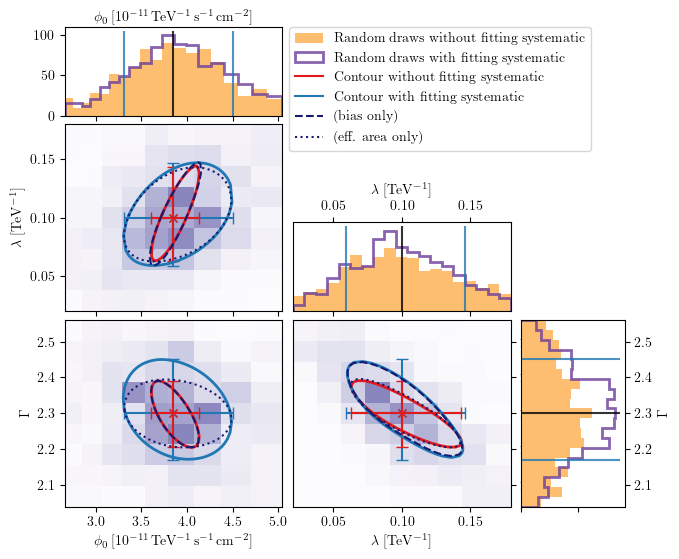

In [20]:
y2 = 2
sss = 2.7

sigs = {"amplitude":2.8, 
        "index":sss,
        "lambda_":sss}

fig3 = plt.figure( figsize = (7,6))
gs = fig3.add_gridspec(5, 5)
ax_a = fig3.add_subplot(gs[0, 0:2])
axs_2 = fig3.add_subplot(gs[1:3, 0:2])
axs_1 = fig3.add_subplot(gs[3:5, 0:2])

ax_c = fig3.add_subplot(gs[2:3,  2:4])
axs_3 = fig3.add_subplot(gs[3:5,  2:4])
ax_b = fig3.add_subplot(gs[3:5,  4:5])

axs = contour_plot([axs_1, axs_2, axs_3])
#axs = plot_scatter([axs_1, axs_2, axs_3])
axs = plot_histo([axs_1, axs_2, axs_3], cmax= 1.7, bb = 10)

axs = histogram([ax_a, ax_b, ax_c], parameters_hist, bb = 20)
ax_a.set_xticklabels([])
axs_2.set_xticklabels([])

ax_a.plot(np.nan, np.nan, color = awo[0], label = "Contour without fitting systematic")
ax_a.plot(np.nan, np.nan, color = aw[0], label = "Contour with fitting systematic")
ax_a.plot(np.nan, np.nan, color = 'midnightblue', linestyle = 'dashed', label = "(bias only)")
ax_a.plot(np.nan, np.nan, color = 'midnightblue', linestyle = 'dotted', label = "(eff. area only)")


ax_a.legend(loc='center left', bbox_to_anchor=(1.0, 0.3))
#axs_1.legend()
plt.show()
fig3.savefig(f"../{c['folder']}/plots/7_summary.pdf") 

In [21]:
len(par_values['index'])

1000

In [22]:
import matplotlib.path as mpltPath
withins, withins_N = [] , []
cases = ["No sys", "all sys", "ereco", "eff area" ]
for r, case in zip([results,results_N,  results_N_ereco, results_N_eff], cases):
    w = []
    print(case)
    for i,p in enumerate(parameter_names):
        try:
            a = r[i][f'{dataset_asimov.models[0].name}.spectral.{p[0]}']    
            b = r[i][f'{dataset_asimov.models[0].name}.spectral.{p[1]}']
            path = mpltPath.Path(np.column_stack((a, b)))
        except:
            dat = r[i].allsegs[0][0]
            a = dat[:, 1]
            b = dat[:, 0]
            path = mpltPath.Path(np.column_stack((a, b)))
            
        masks = []
        for pars0, pars1 in zip(par_values[p[0]], par_values[p[1]]):
            if p[0] == 'amplitude':
                mask = path.contains_points(points = ([(pars0[0]*1e-11, pars1[0])]))
            else:
                mask = path.contains_points(points = ([(pars0[0], pars1[0])]))
                
                
            masks.append(mask[0])
        withins.append(np.count_nonzero(masks)/ len(masks))
        
        masks = []
        for pars0, pars1 in zip(par_values_N[p[0]], par_values_N[p[1]]):
            if p[0] == 'amplitude':
                mask = path.contains_points(points = ([(pars0[0]*1e-11, pars1[0])]))
            else:
                mask = path.contains_points(points = ([(pars0[0], pars1[0])]))
            masks.append(mask[0])
        withins_N.append(np.count_nonzero(masks)/ len(masks))
        
        print(f'{p[0]}, {p[1]}: {withins[-1]*100:.3}, {withins_N[-1]*100:.3}')
    print()
print(withins)



No sys
amplitude, index: 8.3, 11.9
amplitude, lambda_: 9.9, 13.0
lambda_, index: 14.0, 26.5

all sys
amplitude, index: 28.5, 43.0
amplitude, lambda_: 35.0, 41.3
lambda_, index: 25.2, 41.1

ereco
amplitude, index: 8.2, 11.8
amplitude, lambda_: 10.5, 13.5
lambda_, index: 24.1, 39.4

eff area
amplitude, index: 21.2, 32.0
amplitude, lambda_: 32.8, 38.8
lambda_, index: 15.5, 28.1

[0.083, 0.099, 0.14, 0.285, 0.35, 0.252, 0.082, 0.105, 0.241, 0.212, 0.328, 0.155]


3.842459179200168 [[0.60327085]
 [0.69888546]]
2.2654989175629776 [[0.25553202]
 [0.22790469]]
0.10916049521714632 [[0.04625755]
 [0.06498311]]


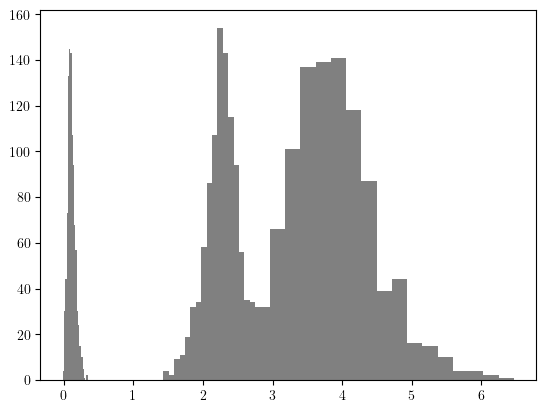

In [23]:

def get_asym_errors(vs, mode =None):
    #fig = plt.figure()
    values, bin_ , _= plt.hist(vs, bins = 20, color = 'grey')# np.histogram(vs, bins =  20)
    modeidx = np.argmax(values)
    if mode is None:
        mode = bin_[modeidx]
    left = [_  for _ in vs if _<= mode]
    #plt.hist(left, bins =bin_, color = 'pink')
    left = np.append(left, mode + ( mode- left))
    #plt.hist(left, bins = bin_,histtype='step', color = 'purple' )
    left_err = np.std(left)
    #plt.errorbar(mode, 10, xerr = left_err, fmt = 'x')
    
    right = [_  for _ in vs if _>= mode]
    right = np.append(right, mode + ( mode- right))
    right_err = np.std(right)
    asymmetric_error = np.array(list(zip([left_err], [right_err]))).T
    return mode, asymmetric_error

asymmetric_errors = []
for i,p in enumerate(['amplitude', 'index', 'lambda_']):
    
    ax = axs[i]
    x_ = [_[0]  for _ in par_values[p]]
    #ax.hist(x_, bins = 30)    
    mode = np.mean(x_)
    mode, asymmetric_error=    get_asym_errors(x_, mode = mode)
    asymmetric_errors.append(asymmetric_error)
    print(mode, asymmetric_error)


3.8819642646064123 [[0.60327085]
 [0.69888546]]
2.2897161921433 [[0.25553202]
 [0.22790469]]
0.10707913585017945 [[0.04625755]
 [0.06498311]]


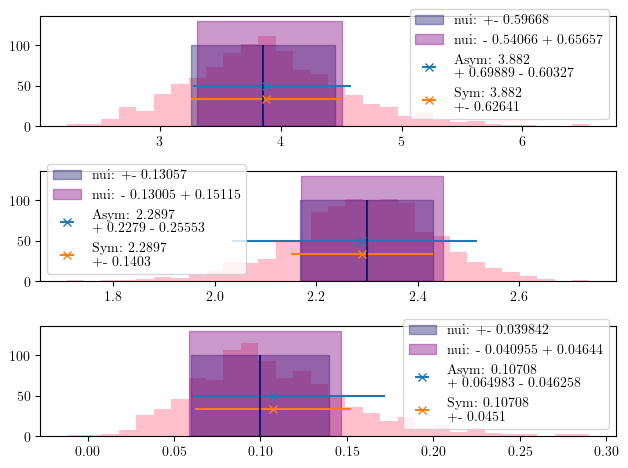

In [24]:
fig, axs = plt.subplots(3,1)
for i,p in enumerate(['amplitude', 'index', 'lambda_']):
    ax = axs[i]
    x_ = [_[0]  for _ in par_values_N[p]]
    ax.hist(x_, bins = 30, color = 'pink')    
    mode = np.mean(x_)
    asymmetric_error= asymmetric_errors[i]
    print(mode, asymmetric_error)
    label = f"Asym: {np.mean(x_):.5} \n+ {asymmetric_error[1][0]:.5} - {asymmetric_error[0][0]:.5}"
    maxy = 100
    ax.errorbar(x = mode,
                    xerr = asymmetric_error,
                   y = maxy/2, fmt = 'x',
                    label = label)
    label = f"Sym: {np.mean(x_):.5} \n +- {np.std(x_):.5}"
    
    ax.errorbar(x = np.mean(x_),
                    xerr = np.std(x_),
                   y = maxy/3, fmt = 'x',
                    label = label)
    plot_nui = True
    if plot_nui:
        parameter = dataset_asimov_N.models[0].parameters[p]
        par_error = parameter.error
        par_value = parameter.value
        axs[i].vlines(par_value, 0, maxy, color = 'midnightblue')
        axs[i].fill_between( (par_value -par_error, par_value+par_error), 0, maxy,
                               color = 'midnightblue', alpha = 0.4,
                               label =   f"nui: +- {par_error:.5}")
    plot_nui_asym = 1
    if plot_nui_asym:
        parameter = dataset_asimov_N.models[0].parameters[p]
        par_error_n = parameter.error_n
        par_error_p = parameter.error_p
        
        par_value = parameter.value
        axs[i].fill_between( (par_value -par_error_n, par_value+par_error_p), 0, maxy + 30,
                               color = 'purple', alpha = 0.4,
                               label =   f"nui: - {par_error_n:.5} + {par_error_p:.5}")
    ax.legend()
plt.tight_layout()

In [25]:
import colors as l

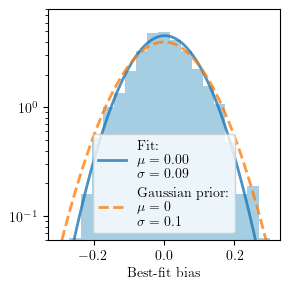

In [26]:
from scipy.stats import norm
from decimal import Decimal, ROUND_HALF_UP

fig,axs = plt.subplots(1,1, figsize = (3,3))
for i, par in enumerate(['bias']):
    x_ = [_[0]  for _ in par_values_N[par]]
    axs.hist(x_, bins =np.linspace(-0.3, 0.3, 20), density=True,color = l.lblue)
axs.set_yscale("log")


mu = Decimal(np.nanmean(x_).item())
mu = mu.quantize(Decimal('0.01'), rounding=ROUND_HALF_UP) 
std = Decimal(np.nanstd(x_).item())
std = std.quantize(Decimal('0.01'), rounding=ROUND_HALF_UP) 
info = f"Fit:\n$\mu = {mu}$ \n $\\sigma = {std}$"
mu, std = norm.fit(np.nan_to_num(x_))

xmin, xmax = -0.3, 0.3
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
axs.plot(x,p,lw=2,color='tab:blue', alpha = 0.8, 
         label=info)

x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, 0, 0.1)
axs.plot(x,p,lw=2,color="tab:orange", linestyle = 'dashed', alpha = 0.8,
         label=f"Gaussian prior:\n$\mu = {0}$ \n $\\sigma = {0.1}$")
axs.legend(loc = 'lower center')
axs.set_xlabel("Best-fit bias")
axs.set_ylabel("")
axs.set_ylim(0.06, 8)
fig.savefig(f"../{c['folder']}/plots/7_bias_hist.pdf", bbox_inches = 'tight')     

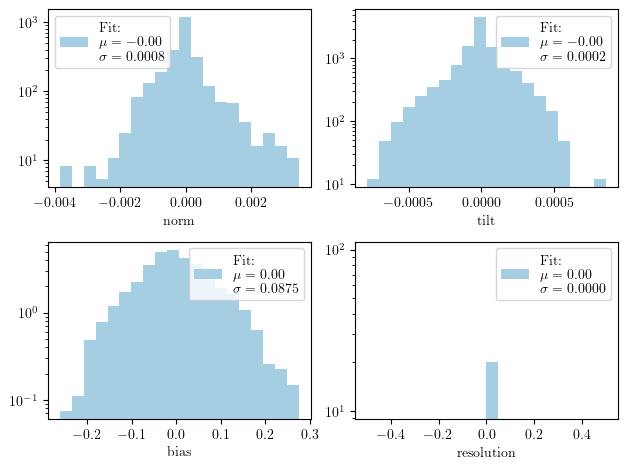

In [27]:
fig,axs = plt.subplots(2,2)
axs = axs.flatten()
for i, par in enumerate(nui_parameters):
    
    x_ = [_[0]  for _ in par_values_N[par]]
    mu = Decimal(np.nanmean(x_).item())
    mu = mu.quantize(Decimal('0.01'), rounding=ROUND_HALF_UP) 
    std = Decimal(np.nanstd(x_).item())
    std = std.quantize(Decimal('0.0001'), rounding=ROUND_HALF_UP) 
    info = f"Fit:\n$\mu = {mu}$ \n $\\sigma = {std}$"
    axs[i].hist(x_, bins =20, label = info , density=True,color = l.lblue)
    axs[i].set_xlabel(par)
    
for a in axs:
    a.set_yscale("log")
    a.legend()
plt.tight_layout()

In [28]:
par_values_N.keys()

dict_keys(['amplitude', 'index', 'lambda_', 'norm_bkg', 'tilt_bkg', 'norm', 'tilt', 'bias', 'resolution'])

## Input contained in random draws 2D

## Distances
distance from the minimum in the likelihood function to the point of the input value tupels. 
Note that at this point the other parameters are refitted. 
If the distance <= 1, the input value is wihtin the 1sigma contour

In [29]:
def compute_fraction(distance):
    within = distance[distance<=1]
    return len(within)/len(distance)

In [30]:
# eff area
infos = np.loadtxt(f"../Eff_area100_PKSflare_crab_cutoff/data/1_P_distances.txt")
N_max = 1001
N_min = 0
distance_1 = infos[N_min:N_max, 0]
distance_2 = infos[N_min:N_max, 1]
distance_3 = infos[N_min:N_max, 2]
distance_1_N = infos[N_min:N_max, 3]
distance_2_N = infos[N_min:N_max, 4]
distance_3_N = infos[N_min:N_max, 5]
print("eff area", len(distance_1))
distances_eff_area = [distance_1, distance_2, distance_3]
distances_eff_area_N = [distance_1_N, distance_2_N, distance_3_N]


# ereco
infos = np.loadtxt(f"../E_reco_PKSflare_crab_cutoff/data/1_P_distances.txt")
distance_1 = infos[N_min:N_max, 0]
distance_2 = infos[N_min:N_max, 1]
distance_3 = infos[N_min:N_max, 2]
distance_1_N = infos[N_min:N_max, 3]
distance_2_N = infos[N_min:N_max, 4]
distance_3_N = infos[N_min:N_max, 5]
print("ereco", len(distance_1))
distances_ereco = [distance_1, distance_2, distance_3]
distances_ereco_N = [distance_1_N, distance_2_N, distance_3_N]


#both
infos = np.loadtxt(f"../{c['folder']}/data/1_P_distances.txt")
distance_1 = infos[N_min:N_max, 0]
distance_2 = infos[N_min:N_max, 1]
distance_3 = infos[N_min:N_max, 2]
distance_1_N = infos[N_min:N_max, 3]
distance_2_N = infos[N_min:N_max, 4]
distance_3_N = infos[N_min:N_max, 5]
print("both", len(distance_1))
distances = [distance_1, distance_2, distance_3]
distances_N = [distance_1_N, distance_2_N, distance_3_N]


eff area 528
ereco 431
both 1000


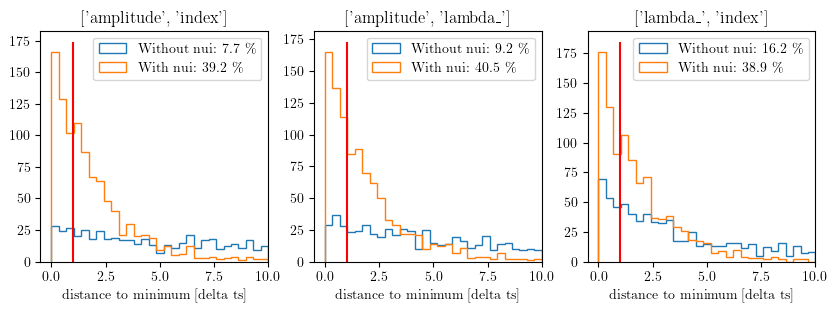

In [31]:

fig, axs = plt.subplots(1,3, figsize = (10,3))
bins = np.linspace(0, 10, 30)

for i in range(len(axs)):
    axs[i].set_title(parameter_names[i])
    axs[i].hist(distances[i], histtype = 'step', bins = bins,
                label= f'Without nui: {compute_fraction(distances[i])*100:.4} \%')
    axs[i].hist( distances_N[i], histtype = 'step', color = 'tab:orange', bins = bins,
           label = f'With nui: {compute_fraction(distances_N[i])*100:.5} \%')

    
    axs[i].legend()
    axs[i].set_xlim(-0.5, 10)
    axs[i].vlines(1, 0, axs[i].get_ylim()[1], color = 'red')
    axs[i].set_xlabel("distance to minimum [delta ts]")
    print()

## Distances in 1D 
meaning I only fixed one of the parameters to the input value, refitted and computed the distance


In [32]:
#both
infos = np.loadtxt(f"../{c['folder']}/data/1_P_distances_1d.txt")
distance_1d_1 = infos[N_min:N_max, 0]
distance_1d_2 = infos[N_min:N_max, 1]
distance_1d_3 = infos[N_min:N_max, 2]
distance_1d_1_N = infos[N_min:N_max, 3]
distance_1d_2_N = infos[N_min:N_max, 4]
distance_1d_3_N = infos[N_min:N_max, 5]
print("both", len(distance_1d_1))
distances_1d = [distance_1d_1, distance_1d_2, distance_1d_3]
distances_N_1d = [distance_1d_1_N, distance_1d_2_N, distance_1d_3_N]


both 1000


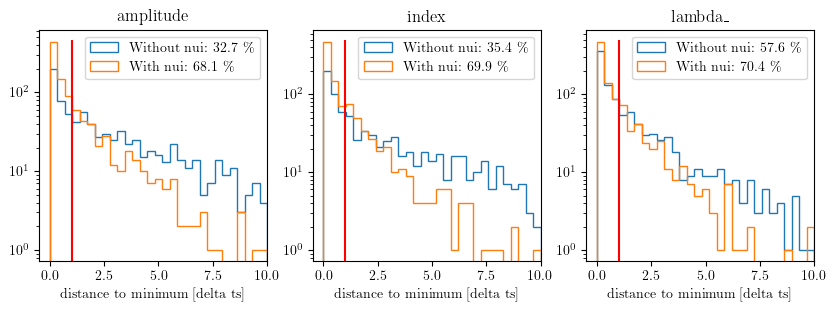

In [33]:

fig, axs = plt.subplots(1,3, figsize = (10,3))
bins = np.linspace(0, 10, 30)
for i in range(len(axs)):
    axs[i].set_title(parameters[i])
    axs[i].hist(distances_1d[i], histtype = 'step', bins = bins,
                label= f'Without nui: {compute_fraction(distances_1d[i])*100:.5} \%')
    
    axs[i].hist( distances_N_1d[i], histtype = 'step', color = 'tab:orange',bins = bins,
           label = f'With nui: {compute_fraction(distances_N_1d[i])*100:.5} \%')

    
    axs[i].legend()
    axs[i].set_xlim(-0.5, 10)
    axs[i].vlines(1, 0, axs[i].get_ylim()[1], color = 'red')
    axs[i].set_xlabel("distance to minimum [delta ts]")

    axs[i].set_yscale("log")

In [34]:
%%time
fractions = []
for j in range(3):
    fractions_ = []
    for i in range(len(distances_N_1d[j])):
        if i > 0:
            d =distances_N_1d[j][:i]
            fractions_.append(compute_fraction(d))
    fractions.append(fractions_)
    
    
    
fractions2d = []
for j in range(3):
    fractions_ = []
    for i in range(len(distances_N[j])):
        if i > 0:
            d =distances_N[j][:i]
            fractions_.append(compute_fraction(d))
    fractions2d.append(fractions_)

CPU times: user 19.6 ms, sys: 1.82 ms, total: 21.5 ms
Wall time: 21 ms


(0.35, 0.42)

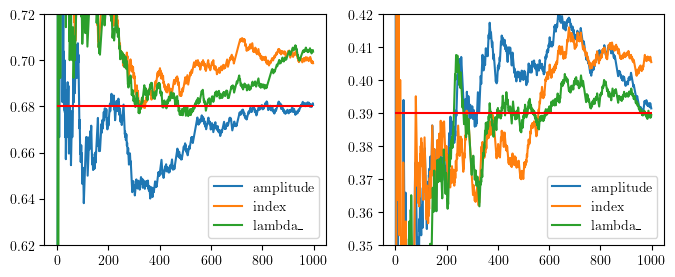

In [35]:
fig, ax = plt.subplots(1,2, figsize = (8,3))
ax[0].plot(np.arange(len(fractions[0])), fractions[0], label = 'amplitude')
ax[0].plot(np.arange(len(fractions[1])), fractions[1], label = 'index')
ax[0].plot(np.arange(len(fractions[2])), fractions[2], label = 'lambda_')
ax[0].hlines(0.68, 0, len(fractions[0]), color = 'red')

ax[0].legend()

ax[0].set_ylim(0.62,0.72)

ax[1].plot(np.arange(len(fractions2d[0])), fractions2d[0], color = 'tab:blue', label = 'amplitude')
ax[1].plot(np.arange(len(fractions2d[1])), fractions2d[1], color = 'tab:orange', label = 'index')
ax[1].plot(np.arange(len(fractions2d[2])), fractions2d[2], color = 'tab:green', label = 'lambda_')

ax[1].hlines(0.39, 0, len(fractions[0]), color = 'red')

ax[1].legend()
ax[1].set_ylim(0.35,0.42)




## Input contained in random draws 1D

In [36]:
parameter_name = ['amplitude', 'index', 'lambda_']
print("without nui")
for p in parameter_name:
    input_parameter = dataset_input.models.parameters[p].value
    
    if p == 'amplitude':
        upper = par_values['amplitude'] + np.array(par_errors['amplitude'])* 1e11 
        lower = par_values['amplitude'] - np.array(par_errors['amplitude'])* 1e11 
    else:
        upper = par_values[p] + np.array(par_errors[p]) 
        lower = par_values[p] -  np.array(par_errors[p]) 
    
    mask = (lower <= input_parameter ) & ((upper > input_parameter ) )
    fraction = sum(mask) / len(mask)
    fraction *= 100
    print(f'{p}:  {fraction[0]:.3} %')
    
    
print()   
print("with nui")
for p in parameter_name:
    input_parameter = dataset_input.models.parameters[p].value
    
    if p == 'amplitude':
        upper = par_values_N['amplitude']  + np.array(par_errors_N['amplitude'])* 1e11 
        lower = par_values_N['amplitude'] -  np.array(par_errors_N['amplitude'])* 1e11
    else:
        upper = par_values_N[p] + np.array(par_errors_N[p])  
        lower = par_values_N[p] - np.array(par_errors_N[p]) 
    
    mask = (lower <= input_parameter ) & ((upper > input_parameter ) )
    fraction = sum(mask) / len(mask)
    fraction *= 100
    
    print(f'{p}:  {fraction[0]:.3} %')
    

without nui
amplitude:  31.6 %
index:  32.9 %
lambda_:  53.9 %

with nui
amplitude:  67.8 %
index:  62.9 %
lambda_:  65.7 %
